In [1]:
import numpy as np
import matplotlib.pyplot as plt
import vice
from vice.toolkit import J21_sf_law

from multizone.src.models.utils import constant, exponential
from multizone.src.models.normalize import integrate_infall
from multizone.src.models import twoinfall, twoinfall_sf_law
from multizone.src.models.diskmodel import two_component_disk

## Constant Infall

In [2]:
ifr = constant()
tau_star = J21_sf_law(1)
eta = 0.6
dt = 0.01
recycling = 0.4
times, sfh_integrated = integrate_infall(ifr, tau_star, eta, recycling=recycling, dt=dt)

In [3]:
name1 = '../data/onezone/int_test/constant'
sz = vice.singlezone(
    name = name1,
    func = ifr,
    mode = "ifr",
    eta = eta,
    tau_star = tau_star,
    Mg0 = 0,
    dt = dt,
)
simtime = np.arange(0., 13.21, 0.01)
sz.run(simtime, overwrite=True)

In [4]:
name2 = '../data/onezone/int_test/constant_inst_rec'
sz = vice.singlezone(
    name = name2,
    func = ifr,
    mode = "ifr",
    eta = eta,
    tau_star = tau_star,
    Mg0 = 0,
    dt = dt,
    recycling = recycling,
)
simtime = np.arange(0., 13.21, 0.01)
sz.run(simtime, overwrite=True)

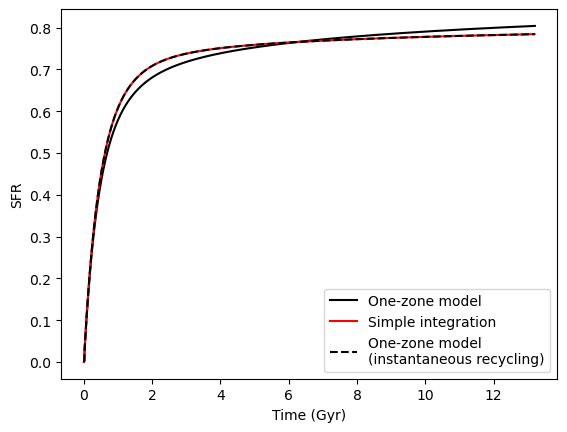

In [5]:
hist1 = vice.history(name1)
hist2 = vice.history(name2)

fig, ax = plt.subplots()
ax.plot(hist1['time'], hist1['sfr'], 'k-', label='One-zone model')
ax.plot(times, sfh_integrated, 'r-', label='Simple integration')
ax.plot(hist2['time'], hist2['sfr'], 'k--', label='One-zone model\n(instantaneous recycling)')
ax.set_xlabel('Time (Gyr)')
ax.set_ylabel('SFR')
ax.legend()
plt.show()

In [6]:
mstar = sum([sfr * dt * 1e9 * (1 - recycling) for sfr in sfh_integrated])
print(mstar)
print(hist1['mstar'][-1])
print(hist2['mstar'][-1])
print(sum(hist2['sfr']) * dt * 1e9 * (1 - recycling))

5792176560.030154
5764287000.0
5770704000.0
5797176521.556


## Exponential Infall

In [7]:
ifr = exponential(timescale=1, norm=1)
tau_star = twoinfall_sf_law(1, factor=1)
eta = 2
dt = 0.01
recycling = 0.4
times, sfh_integrated = integrate_infall(ifr, tau_star, eta)

In [8]:
name = '../data/onezone/int_test/exponential'
sz = vice.singlezone(
    name = name,
    func = ifr,
    mode = "ifr",
    eta = eta,
    tau_star = tau_star,
    Mg0 = 0,
    dt = dt,
    # recycling = recycling
)
simtime = np.arange(0., 13.21, 0.01)
sz.run(simtime, overwrite=True)

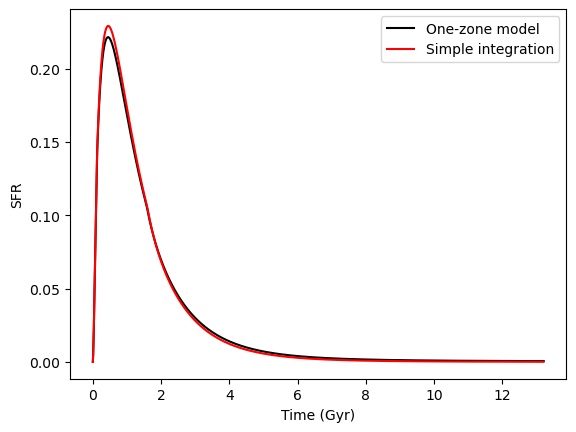

In [9]:
hist = vice.history(name)

fig, ax = plt.subplots()
ax.plot(hist['time'], hist['sfr'], 'k-', label='One-zone model')
ax.plot(times, sfh_integrated, 'r-', label='Simple integration')
ax.set_xlabel('Time (Gyr)')
ax.set_ylabel('SFR')
ax.legend()
plt.show()

In [10]:
mstar = sum(sfh_integrated) * dt * 1e9 * (1 - recycling)
print(mstar)
print(hist['mstar'][-1])
print(sum(hist['sfr']) * dt * 1e9 * (1 - recycling))

231522979.24543843
219961400.0
234011673.93360004


## Two-Infall Model

In [11]:
radius = 8
dr = 0.1
area = np.pi * ((radius + dr)**2 - radius**2)
ifr = twoinfall(radius, first_timescale=1, second_timescale=10, onset=4)
tau_star = twoinfall_sf_law(area, onset=4)
eta = 2.15
dt = 0.01
recycling = 0.4
times, sfh_integrated = integrate_infall(ifr, tau_star, eta, recycling=recycling, dt=dt)

In [12]:
name1 = '../data/onezone/int_test/twoinfall1'
sz = vice.singlezone(
    name = name1,
    func = ifr,
    mode = "ifr",
    eta = eta,
    tau_star = tau_star,
    Mg0 = 0,
    dt = dt,
    recycling = recycling
)
simtime = np.arange(0., 13.21, 0.01)
sz.run(simtime, overwrite=True)

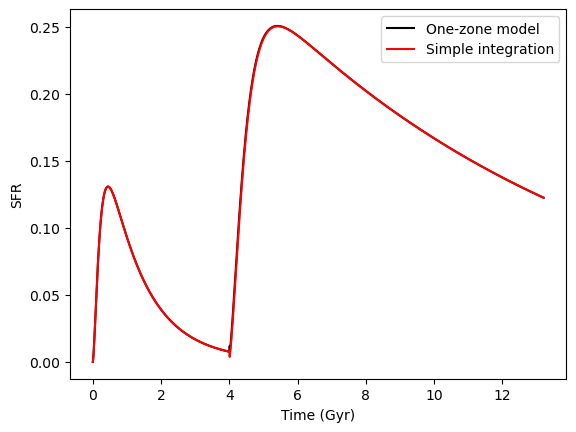

In [13]:
hist = vice.history(name1)

fig, ax = plt.subplots()
ax.plot(hist['time'], hist['sfr'], 'k-', label='One-zone model')
ax.plot(times, sfh_integrated, 'r-', label='Simple integration')
ax.set_xlabel('Time (Gyr)')
ax.set_ylabel('SFR')
ax.legend()
plt.show()

In [14]:
mstar = sum(sfh_integrated) * dt * 1e9 * (1 - recycling)
print(mstar)
print(hist['mstar'][-1])
print(sum(hist['sfr']) * dt * 1e9 * (1 - recycling))

1124819140.5024881
1124045000.0
1127343544.1100001


In [15]:
mstar_at_onset = sum(sfh_integrated[:400]) * dt * 1e9 * (1 - recycling)
print(mstar_at_onset)
print(hist['mstar'][399])
print(sum(hist['sfr'][:400]) * dt * 1e9 * (1 - recycling))

121420561.83851571
125302600.0
121425390.432


In [16]:
print(mstar_at_onset / (mstar - mstar_at_onset))

0.12100930220589656


In [23]:
print(hist['mstar'][399] / (hist['mstar'][-1] - hist['mstar'][399]))

0.1332803663486757


In [17]:
mw_disk = two_component_disk()
print(mw_disk.thick_to_thin(0))
print(mw_disk.thick_to_thin(8))

0.27
0.12131882031164984


### Variant

In [18]:
radius = 8
dr = 0.1
area = np.pi * ((radius + dr)**2 - radius**2)
ifr = twoinfall(radius, first_timescale=1, second_timescale=1, onset=4)
tau_star = twoinfall_sf_law(area, onset=4)
eta = 2.15
dt = 0.01
recycling = 0.4
times, sfh_integrated = integrate_infall(ifr, tau_star, eta, recycling=recycling, dt=dt)

In [19]:
name2 = '../data/onezone/int_test/twoinfall2'
sz = vice.singlezone(
    name = name2,
    func = ifr,
    mode = "ifr",
    eta = eta,
    tau_star = tau_star,
    Mg0 = 0,
    dt = dt,
    recycling = recycling
)
simtime = np.arange(0., 13.21, 0.01)
sz.run(simtime, overwrite=True)

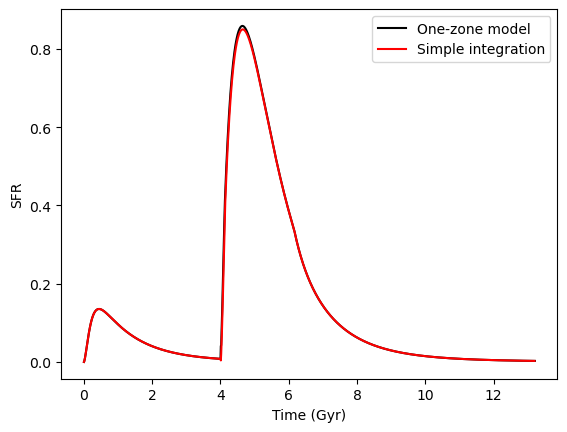

In [20]:
hist = vice.history(name2)

fig, ax = plt.subplots()
ax.plot(hist['time'], hist['sfr'], 'k-', label='One-zone model')
ax.plot(times, sfh_integrated, 'r-', label='Simple integration')
ax.set_xlabel('Time (Gyr)')
ax.set_ylabel('SFR')
ax.legend()
plt.show()

In [21]:
mstar = sum(sfh_integrated) * dt * 1e9 * (1 - recycling)
print(mstar)
print(hist['mstar'][-1])
print(sum(hist['sfr']) * dt * 1e9 * (1 - recycling))

1134121177.888187
1099040000.0
1144258069.74


In [24]:
mstar_at_onset = sum(sfh_integrated[:400]) * dt * 1e9 * (1 - recycling)
print(mstar_at_onset)
print(hist['mstar'][399])
print(sum(hist['sfr'][:400]) * dt * 1e9 * (1 - recycling))

125260442.91570446
129253500.0
125265336.51599999


In [25]:
print(mstar_at_onset / (mstar - mstar_at_onset))

0.1241602914788046


In [26]:
print(hist['mstar'][399] / (hist['mstar'][-1] - hist['mstar'][399]))

0.1332803663486757
